# 1. Imbalanced learning
Working with imbalanced data is normal in real world. Some cases of that can be solved by choosing the right metric or make sure the distribution between training and testing set are the same. Otherwise, there are 2 methods can be used to reduce imbalanced in machine learning are: upsampling (over-sampling) or downsampling (under-sampling)

Both methods have random sampler which random duplicates/drops the samples in minority/majority class.

## 1.1. Over-sampling 

Over-sampling is generating the new observations in minoriry class. This method should be used only when the data size is small, because of data leakage and model performance problem. The same data point can be shown up in both training and testing set, so always do it after splitting the data into training and validation folds. Over sampling can hurt model performance by training the operation points - it's a bit different from real world data.

### Synthetic Minority  

[Synthetic Minority Oversampling Techique (SMOTE)]() uses the algorithm to generate new data points. It works by selecting points that are close in the feature space, drawing a line between the points and drawing a new sample as a point along that line. Called $x_i$ and $x_j$ are the points in minor class, $x_j$ is one of $k$ nearest neighbors of $x_i$. The new sample $x_n$ will be computed by:

$$x_n = x_i + \lambda (x_j-x_i)$$

With $\lambda$ is a random number in range $[0,1]$. There are some variants of SMOTE:
- [Borderline SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.BorderlineSMOTE.html#imblearn.over_sampling.BorderlineSMOTE): In some cases, the instance of minority is so close to the majority which can lead to misclassified. These instances are called borderline points that a point has more than a half of its neighbors in majority class. To improve the prediction, we need to fullfill the *border* so the algorithm synthesize the border line points instead of others
- [SVM SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SVMSMOTE.html#imblearn.over_sampling.SVMSMOTE): Similar to borderline, svm create new points based on support vectors, but the new point can lie both outside and inside the distance between support vector to its neighbors. If fewer than a half of $k$ nearest neighbors of a point are majority class, the new points will be created outside to expand the minority class area.
- [Kmeans SMOTE](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.KMeansSMOTE.html#imblearn.over_sampling.KMeansSMOTE): Using kmean to cluster data set before oversampling, any cluster with at least 50% of minority instance will be choosen for generating new samples.

### Adaptive Synthetic
Adaptive Synthetic Sampling Approach (ADASYN) works similarity to the regular SMOTE. However, the number of samples generated for each $x_i$ is proportional to the number of samples which are not from the same class with $x_i$ in a given neighborhood. The algorithms generated more new samples where the density of minority is low and fewer or none where the density is high. This will improve the learning process for minority class

Called $n_s$ is number of samples in minority class and $n_l$ is number of samples in majority class. 
- Compute the total numbers of samples will be generated $G = (n_l - n_s) * \beta$ with $\beta$ in range $(0,1]$, if $\beta=1$, the ratio $\frac{n_l}{n_s}=1$
- Find $k$ nearest neighbors of $x_i$ - put into set $S_i$
- Find $\delta_i$ as the number of samples in k-nearest neighbors which belong to the majority class. Calculate ratio $r_i = \frac{\delta_i}{k}$
- Normalize $r_i$ according to $$r_i = \frac{r_i}{\sum_{i=1}^{n_s} r_i}$$
- Calculate the number of samples need to generated for each $x_i$: $g_i = r_i\times G$
- From $S_i$, randomly pick $g_i$ samples and generate new samples following the formula:
$$x_n = x_i + \lambda\times (x_i - x_j)$$


### Implementation
In Imbalance-learn package, all algorithms have a parameter called `sampling_strategy` which defines sampling information. There are 5 ways to use a sampling strategy for different family of samplers:
1. Sampling strategy as float
    - For under-sampling, it corresponds to the ratio between number of samples in minority class and majority class after resampling:  $\alpha = \frac{n_s}{n_l'}$
    - For over-sampling, it corresponds to the ratio between number of samples in minority class after resampling and majority class:  $\alpha = \frac{n_s'}{n_l}$
2. Sampling strategy as string: This string define which class will be targeted by the sampler. In both under and over-sampling, the number of samplers will be equalized
    - `minority`/`majority`: resample only 1 class
    - `not minority`/`not majority`/`auto`: resample all classes except 1 class
    - `all`: resample all classes
3. Sampling strategy as a dictionary: The dictionary contains the keys are the targeted class and values are the number of samples for each class. This working for both under and over-sampling, except cleaning methods.
4. Sampling strategy as a list: This method only works with cleaning methods. It is a list of targeted classes.
5. Sampling strategy as a callable: A function which is defined by user. It taking y as input and return a dict which have keys are the targeted classes and values are the number of samples for each class.

In [14]:
import imblearn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

In [25]:
from imblearn.datasets import make_imbalance
import imblearn.over_sampling as io
import imblearn.under_sampling as iu

In [29]:
df = pd.read_csv('data/breast_cancer.csv')
X = df.drop(columns='target')
y = df['target']

In [30]:
sampling_strategy = {0:50,1:357}
X_imb, y_imb = make_imbalance(X, y, sampling_strategy=sampling_strategy)

In [37]:
print(Counter(y))
print(Counter(y_imb))

Counter({1: 357, 0: 212})
Counter({1: 357, 0: 50})


In [53]:
def plot_resampling(X, y, sampler, ax):
    X_res, y_res = sampler.fit_resample(X,y)
    ax.scatter(X_res.iloc[:,0],X_res.iloc[:,4],c=y_res, cmap='Spectral')
    title = sampler.__class__.__name__
    ax.set_title(title)
    sns.despine(ax=ax)

In [39]:
random = io.RandomOverSampler()
smote = io.SMOTE(k_neighbors=5)
bor_smote1 = io.BorderlineSMOTE(kind='borderline-1', k_neighbors=20)
bor_smote2 = io.BorderlineSMOTE(kind='borderline-2', k_neighbors=20)
svm_smote = io.SVMSMOTE()

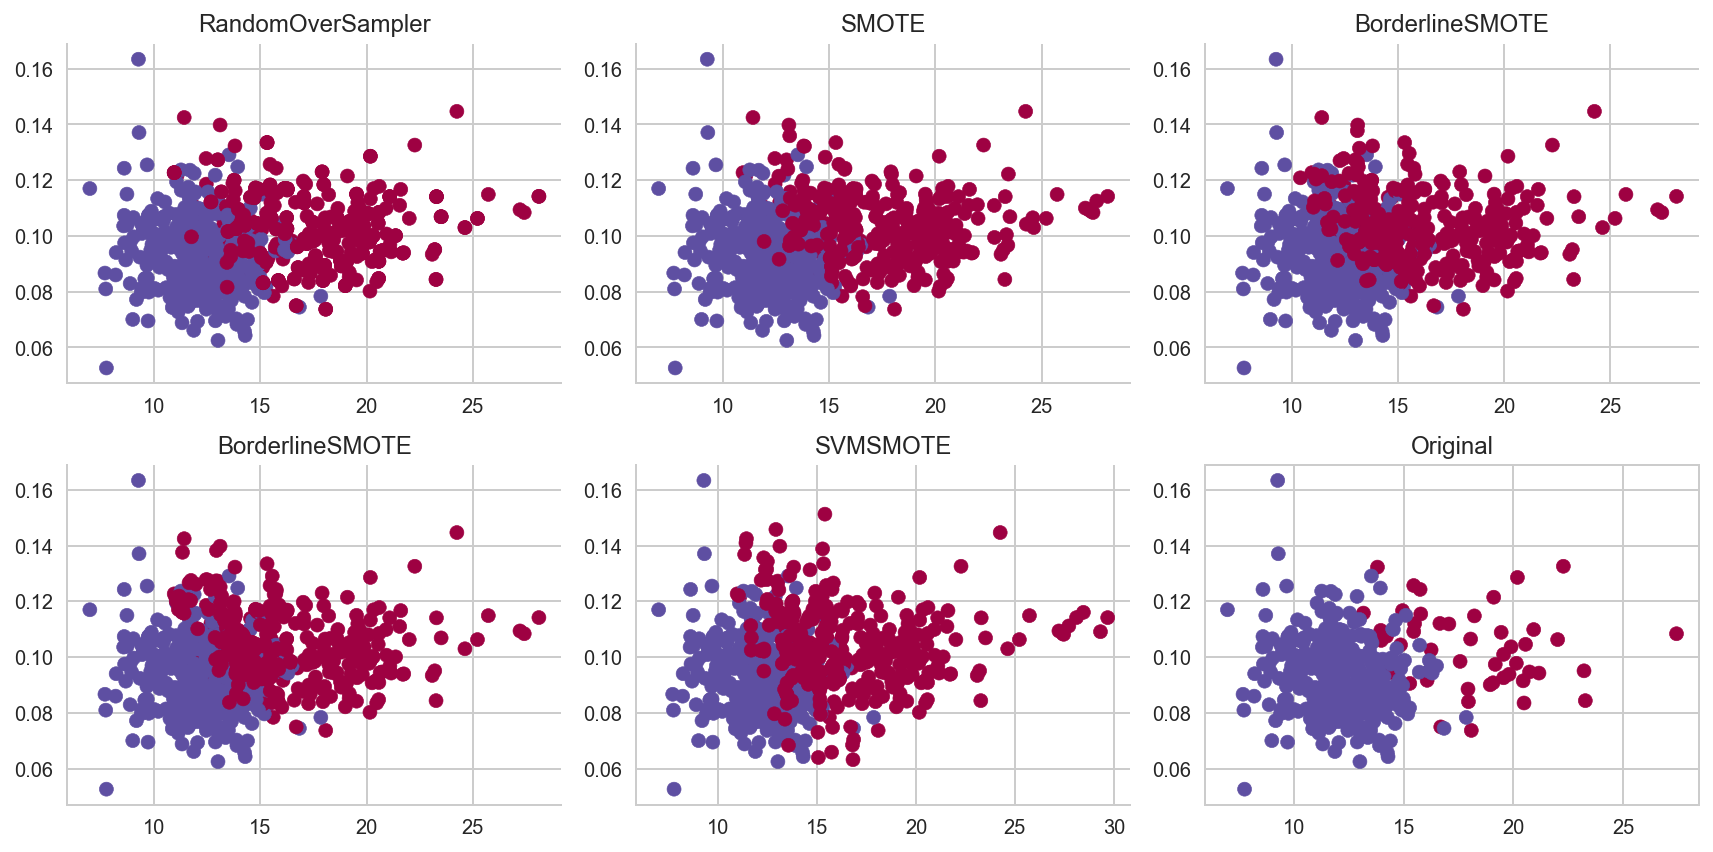

In [56]:
samplers = [random, smote, bor_smote2, bor_smote1,svm_smote]
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12,6))

for ax, sampler in zip(axs.ravel(), samplers):
    plot_resampling(X,y,sampler,ax)

axs[1,2].scatter(X_imb.iloc[:,0], X_imb.iloc[:,4],c=y_imb, cmap='Spectral')
axs[1,2].set_title("Original")
fig.tight_layout()

## 1.2. Under-sampling 

Opposite to over-sampling, under-sampling is the process of reducing samples in majority class. It's simple and suitable for large dataset, but the risk is the most informative samples may be dropped and lead to bad model prediction.

### Near miss
[Near Miss](https://imbalanced-learn.org/stable/under_sampling.html#mathematical-formulation) choses the samples to keep using the minimum average distance to $N$ minority samples:
- NearMiss-1: keeping the samples which have minimum distance to $N$ closest samples
- NearMiss-2: keeping the samples which have minimum distance to $N$ farthest samples
- NearMiss-3: keeping the samples for each closest record in the minority class.

The NearMiss-3 seems the most accurate version, because it will only keep those majority class points that are on the decision boundary.

### Tomek links 
A [tomek link](https://imbalanced-learn.org/stable/under_sampling.html#tomek-s-links) exist if two samples in different class are the nearest neighbor of each other then the algorithm will remove the point in majority class or both of them. This method will remove the points in majority class which easy to misclassified.


### Condensed Nearest Neighbors
CNN uses 1-NN rule to decide if a sample should be remove or not. Firstly, get all minority sample in a set C and others in set S. Then we go through set S, sample by sample, and classify each sample using 1-NN rule. If the sample is misclassified, add it to C otherwise do nothing. Repeat all step until there is no sample to be added Set C will be used in classify instead of all dataset. This method has lower execution time and reduce space complexity but it sensitive to noise

### Edited Nearest Neighbors

[Edited Nearest Neighbors (ENN)](https://imbalanced-learn.org/stable/under_sampling.html#edited-data-set-using-nearest-neighbours) uses a nearest neighbor algorithm to classify and edit the dataset by removing samples which do not the same with their neighbors. Assume the instance $p$ has 3 nearest neighbor, if $p$ in majority class but misclassified by these 3 neighbors then $p$ will be dropped. If $p$ in minority class and 3 neighbors in majority class, then these neighbors of $p$ will be removed.

In [ENN](https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.EditedNearestNeighbours.html#imblearn.under_sampling.EditedNearestNeighbours) function, we can set `kind=mode` for dropping just in case $p$ in majority and `kind=all` for both cases, notice that `kind=all` will remove more samples from the dataset.

### Implementation

In [58]:
random_under = iu.RandomUnderSampler()
cnn = iu.CondensedNearestNeighbour()
enn = iu.EditedNearestNeighbours()
nearmiss = iu.NearMiss(version=3)
tomek = iu.TomekLinks()

C:\Users\ADMIN\anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_selection\_nearmiss.py:188: UserWarning: The number of the samples to be selected is larger than the number of samples available. The balancing ratio cannot be ensure and all samples will be returned.
  warnings.warn(


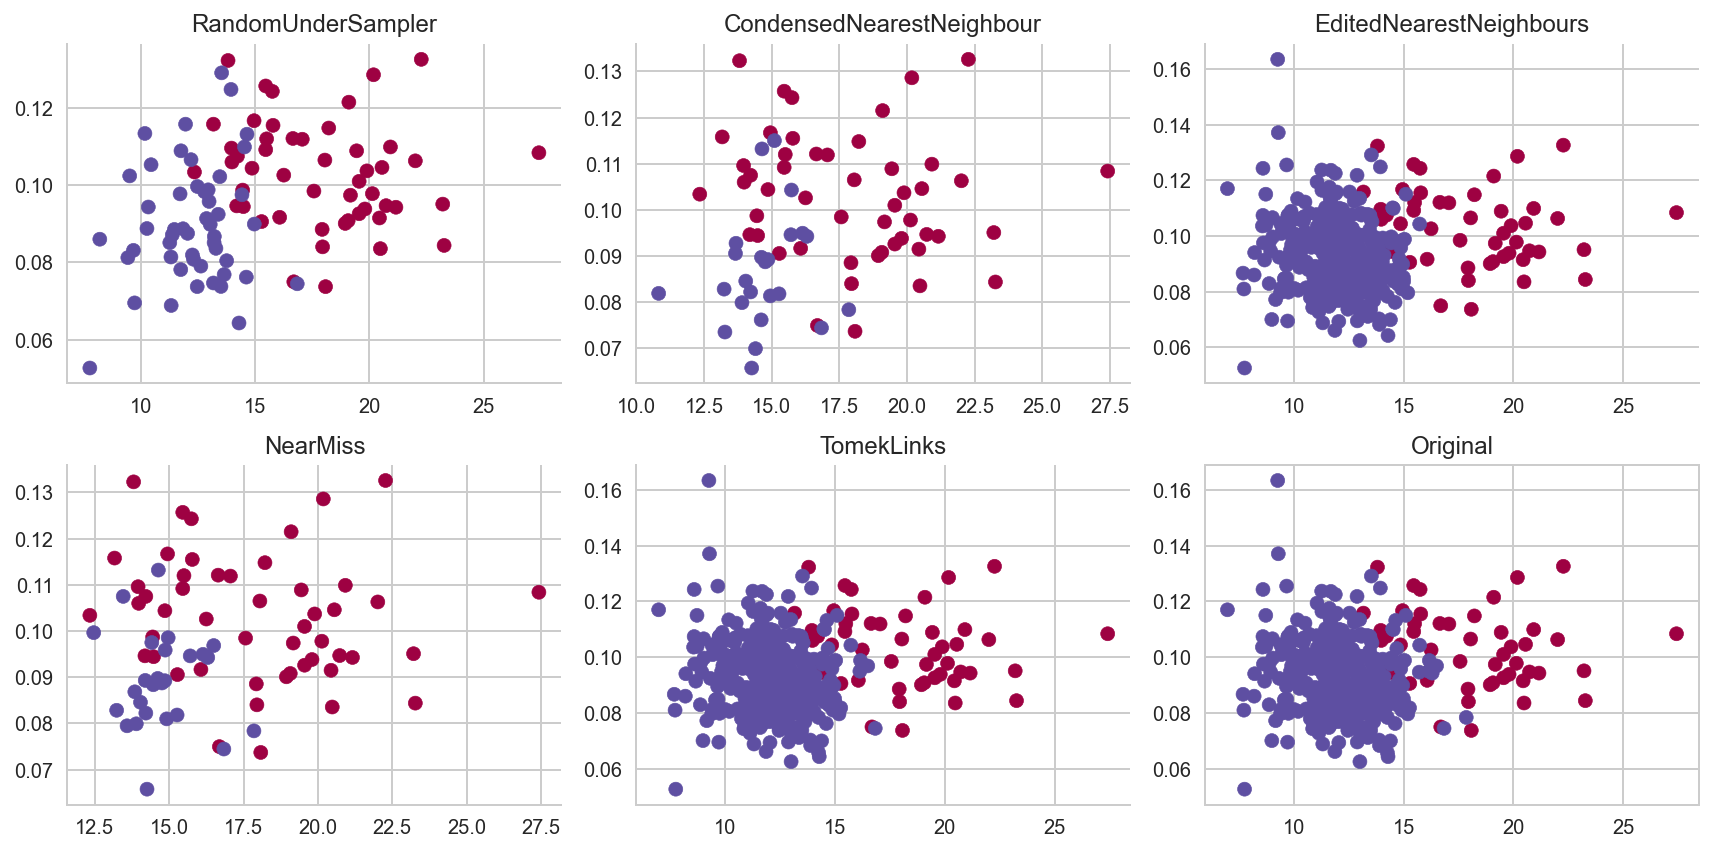

In [60]:
samplers = [random_under, cnn, enn, nearmiss,tomek]
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(12,6))

for ax, sampler in zip(axs.ravel(), samplers):
    plot_resampling(X_imb,y_imb,sampler,ax)

axs[1,2].scatter(X_imb.iloc[:,0], X_imb.iloc[:,4],c=y_imb, cmap='Spectral')
axs[1,2].set_title("Original")
fig.tight_layout()

## 1.3. Combination
Tomek links and ENN actually are 2 cleaning methods. Cleaning methods do not allow to specify the number of samples to have in each class, they have been added to the pipeline after using over-sampling to drop noisy samples in the space. [SMOTE-Tomek](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTETomek.html) and [SMOTE-ENN](https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTEENN.html) is 2 popular algorithms which combine between SMOTE and cleaning method.

In [14]:
import imblearn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

In [61]:
from imblearn.datasets import make_imbalance
from imblearn import combine

In [29]:
df = pd.read_csv('data/breast_cancer.csv')
X = df.drop(columns='target')
y = df['target']

In [30]:
sampling_strategy = {0:50,1:357}
X_imb, y_imb = make_imbalance(X, y, sampling_strategy=sampling_strategy)

In [37]:
print(Counter(y))
print(Counter(y_imb))

Counter({1: 357, 0: 212})
Counter({1: 357, 0: 50})


In [62]:
smote_enn = combine.SMOTEENN()
smote_tomek = combine.SMOTETomek()

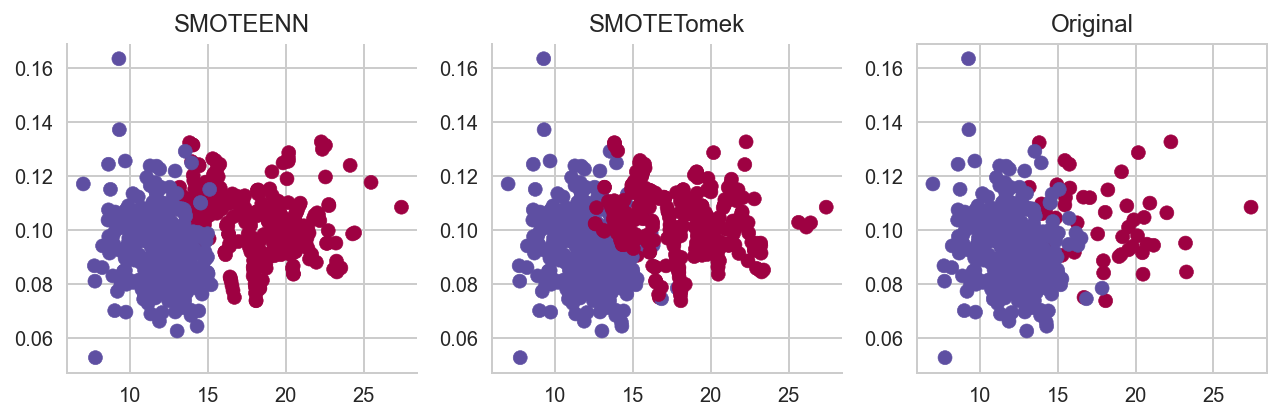

In [64]:
samplers = [smote_enn, smote_tomek]
fig, axs = plt.subplots(ncols=3, figsize=(9,3))

for ax, sampler in zip(axs.ravel(), samplers):
    plot_resampling(X_imb,y_imb,sampler,ax)

axs[2].scatter(X_imb.iloc[:,0], X_imb.iloc[:,4],c=y_imb,cmap='Spectral')
axs[2].set_title("Original")
fig.tight_layout()

### Ensemble method 
In sklearn ensemble classifier, bagging and boosting method build serveral estimators on different subset of data. However, these classifiers do not allow to balance each subset of data. Therefore, ibm package introduce 3 function of bagging and boosting which integrated `sample_stategy` into the classifier. The limit of this method is it just use ensemble classifier from sklearn

# [w]. Uplift modeling

# [w]. Ranking

# References

- *Imbalance learn - [User guide](https://imbalanced-learn.org/stable/user_guide.html)*
- *Medium - [Oversampling and undersampling: adasyn vs enn](https://medium.com/quantyca/oversampling-and-undersampling-adasyn-vs-enn-60828a58db39)*
- *paper - [Borderline SMOTE](https://sci2s.ugr.es/keel/keel-dataset/pdfs/2005-Han-LNCS.pdf )*
- *paper - [ADASYN](https://www.diva-portal.org/smash/get/diva2:1519153/FULLTEXT01.pdf)*

---
*&#9829; By Quang Hung x Thuy Linh &#9829;*